# Predicting the sale price of bulldozers using machine learning

In this notebook, we are going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition
> How well can we pridict the future sale price of a bulldozer, given its charecterstics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bulldozer bluebook competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

1. The data is split into three parts:

    * Train.csv is the training set, which contains data through the end of 2011.
    * Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
    * Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

2. The key fields in train.csv are:

    * SalesID: the uniue identifier of the sale
    * MachineID: the unique identifier of a machine.  A machine can be sold multiple times
    * saleprice: what the machine sold for at auction (only provided in train.csv)
    * saledate: the date of the sale

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project, check: https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, out goal for this project will be to build a machine leqrning model which minimizes RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all of the features of the dataset.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# Check if there are missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

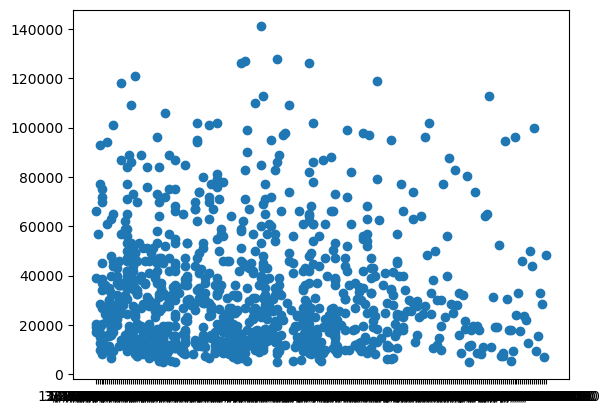

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

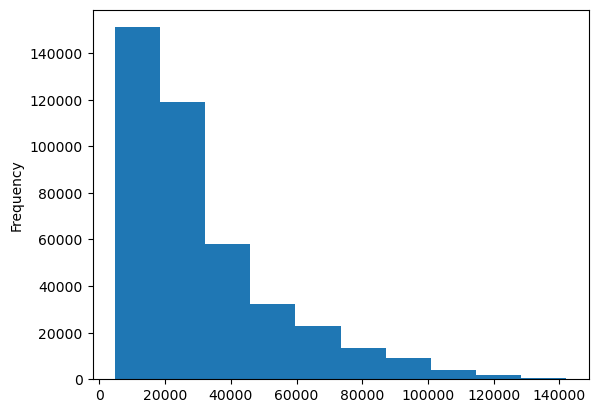

In [6]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time and data component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [7]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:100]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
        ...    
95   2005-12-15
96   2004-01-29
97   2008-09-18
98   2005-11-03
99   2006-06-01
Name: saledate, Length: 100, dtype: datetime64[ns]

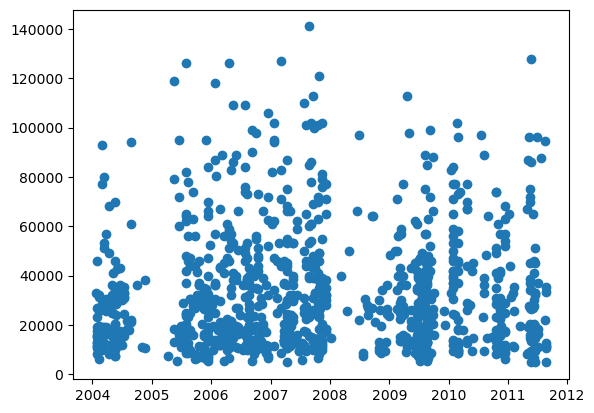

In [10]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [13]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it is a good idea to sort it by date.

In [14]:
# Sort dataframe in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make copy of original DataFrame

Making a copy so that when we manipulate the copy, we still have the original data.

In [15]:
# Make a copy including the changes in order
df_tmp = df.copy()

### Add datetime parameter for `saledate` column

In [16]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [17]:
# We have enriched our DataFrame with datetime feature, therefore saledate can be removed
df_tmp.drop("saledate", axis=1,inplace=True)

In [18]:
# Check the values of different states (columns)
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We have done enough EDA (could always do more) but lets start to do some model driven EDA

In [19]:
# Let's build a mchine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

Cannot fit model because all column are not numeric and there are missing values

### convert strings to categories

One way we can turn all our data into numbers is by converting them into pandas categories.

In [20]:
# Find the columns which contain strings (using is_string_dtype and is_object_dtype)
# Turn string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        df_tmp[label] = content.astype("category").cat.as_ordered()
    elif pd.api.types.is_object_dtype(content): # is_object_dtype is used because is_string_dtype was not finding all columns
        print(label)
        df_tmp[label] = content.astype("category").cat.as_ordered()

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [21]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [22]:
df_tmp.state.cat.categories # ordered alphabetically by using as_ordered()

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [23]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories now we have a way to access all our data in the form of numbers.

In [24]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data 

In [25]:
# Export currect tmp DataFrame
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", index=False)

In [26]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Fill missing values
**Fill numerical missing values**

In [27]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [28]:
# Check which numeric columns have missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [29]:
# Fill numeric rows with the median values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

Using median to fill missing values as mean is more sensitive to outlier values.
Hence, median is more robust.

### Filling and turning categorical variables into numbers

In [30]:
# Check for columns which are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [31]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate if sample had missing data
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add 1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [32]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [33]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [34]:
df_tmp.tail().T

,412693,412694,412695,412696,412697
SalesID,6302984,6324811,6313029,6266251,6283635
SalePrice,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1915521,1919104,1918416,509560,1869284
ModelID,5266,19330,17244,3357,4701
datasource,149,149,149,149,149
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,True,True,True
Blade_Type_is_missing,False,True,True,True,True
Travel_Controls_is_missing,False,True,True,True,True
Differential_Type_is_missing,True,True,True,True,False


In [35]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now all our data is numeric and has no missing values, we can fit a machine learning model

In [36]:
%%time
# Instantiate

X = df_tmp.drop("SalePrice", axis=1)
y = df_tmp["SalePrice"]

model.fit(X, y)

CPU times: user 7min 40s, sys: 1.64 s, total: 7min 42s
Wall time: 37.2 s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [37]:
# Score the model
model.score(X, y)

0.9875468079970562

### Splitting data into train/validation sets

In [38]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [39]:
# Split data into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [40]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

In [41]:
# Create evaluation function (to use RMSLE)
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on few diffrent levels
def show_score(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Taining MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training r^2": r2_score(y_train, train_preds),
              "Valid r^2": r2_score(y_valid, val_preds)}
    return scores

In [42]:
%%time
model_rfr = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model_rfr.fit(X_train, y_train)
show_score(model_rfr)

CPU times: user 20.3 s, sys: 215 ms, total: 20.5 s
Wall time: 1.78 s


{'Taining MAE': np.float64(5561.2988092240585),
 'Valid MAE': np.float64(7177.26365505919),
 'Training RMSLE': np.float64(0.257745378256977),
 'Valid RMSLE': np.float64(0.29362638671089003),
 'Training r^2': 0.8606658995199189,
 'Valid r^2': 0.8320374995090507}

## Hyperparameter tuning with RandomizedSearchCV

In [43]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20,2),
           "max_features": [0.5, 1, "sqrt", "log2"]}#,
           #"max_samples": [10000, 100000, 400000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(model,
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

#  Fit the RandomRandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1h 41min 9s, sys: 55.7 s, total: 1h 42min 5s
Wall time: 9min 52s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [44]:
rs_model.best_params_

{'n_estimators': np.int64(60),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(1),
 'max_features': 0.5,
 'max_depth': None}

In [45]:
show_score(rs_model)

{'Taining MAE': np.float64(3081.4361816362853),
 'Valid MAE': np.float64(5957.397591372951),
 'Training RMSLE': np.float64(0.14988348511846789),
 'Valid RMSLE': np.float64(0.2459196966199198),
 'Training r^2': 0.9554132405188465,
 'Valid r^2': 0.881359211660316}

In [56]:
%%time
ideal_model_video = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model = RandomForestRegressor(n_estimators=60,
                                    min_samples_leaf=1,
                                    min_samples_split=16,
                                    max_features=0.5,
                                    max_depth=None,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

ideal_model_video.fit(X_train, y_train)
ideal_model.fit(X_train, y_train)

CPU times: user 3min 8s, sys: 620 ms, total: 3min 8s
Wall time: 16 s


RandomForestRegressor(max_features=0.5, min_samples_split=16, n_estimators=60,
                      n_jobs=-1, random_state=42)

In [57]:
show_score(ideal_model_video)

{'Taining MAE': np.float64(2953.8161137163484),
 'Valid MAE': np.float64(5951.247761444453),
 'Training RMSLE': np.float64(0.14469006962371858),
 'Valid RMSLE': np.float64(0.24524163989538328),
 'Training r^2': 0.9588145522577225,
 'Valid r^2': 0.8818019502450094}

In [58]:
show_score(ideal_model)

{'Taining MAE': np.float64(3081.4361816362853),
 'Valid MAE': np.float64(5957.397591372951),
 'Training RMSLE': np.float64(0.14988348511846786),
 'Valid RMSLE': np.float64(0.24591969661991983),
 'Training r^2': 0.9554132405188465,
 'Valid r^2': 0.881359211660316}

In [91]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


## Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [92]:
def preprocess_data(df):
    """
    Performs transformations on df and return transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    df.drop("saledate", axis=1,inplace=True)

    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # we add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1

    return df

In [93]:
# Process test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [94]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [95]:
# Find the difference in columns of df_test and X_train
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [96]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test.insert(loc=56, column='auctioneerID_is_missing', value=False)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [97]:
df_test.columns.get_loc('auctioneerID_is_missing')

56

**Finally, now the test DataFrame has same features as training DataFrame.**

In [98]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [99]:
test_preds

array([17554.93827792, 18898.10421766, 51561.97320288, ...,
       12767.20309199, 16324.99130627, 24625.78766906])

In [101]:
# Format predictions into the format Kaggle requires
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17554.938278
1,1227844,18898.104218
2,1227847,51561.973203
3,1227848,72504.182029
4,1227863,54041.969943
...,...,...
12452,6643171,42041.797254
12453,6643173,11543.067440
12454,6643184,12767.203092
12455,6643186,16324.991306


In [103]:
# Export prediction data to csv
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

## Feature importance

Feature importance seeks to figure out which attributes of the data were most important when predicting the **target variable** (Sale Price)

In [105]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.40309838e-02, 1.83287025e-02, 4.15542710e-02, 1.72185101e-03,
       3.14086714e-03, 2.10605271e-01, 3.08892567e-03, 1.00525814e-03,
       4.81104490e-02, 4.31859326e-02, 6.29567495e-02, 4.77716791e-03,
       1.29065455e-02, 1.60197577e-01, 4.62344953e-02, 5.56044221e-03,
       3.59753942e-03, 3.21427425e-03, 3.18901935e-03, 5.95273930e-02,
       4.41060184e-04, 7.26445295e-05, 8.19212154e-04, 3.04894081e-04,
       1.02368875e-03, 4.24148670e-05, 1.67960842e-03, 4.39184361e-03,
       2.21856683e-04, 1.69410838e-03, 3.16156027e-03, 3.93060997e-03,
       2.85145486e-03, 2.69344108e-03, 6.96175370e-04, 5.23301156e-03,
       8.61708297e-04, 1.58161046e-02, 1.60558008e-03, 4.26904072e-03,
       7.73671903e-04, 9.25071555e-04, 1.13286728e-03, 5.70882275e-04,
       5.14687096e-04, 3.30555114e-04, 4.79271860e-04, 2.39309091e-03,
       1.77211622e-03, 2.35133534e-04, 1.94004956e-04, 7.29764587e-02,
       3.58226871e-03, 5.17338601e-03, 2.64422609e-03, 9.25893774e-03,
      

In [115]:
# Create function for plotting important features
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features":columns,
                        "feature_importances": importances,})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the DataFrame
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

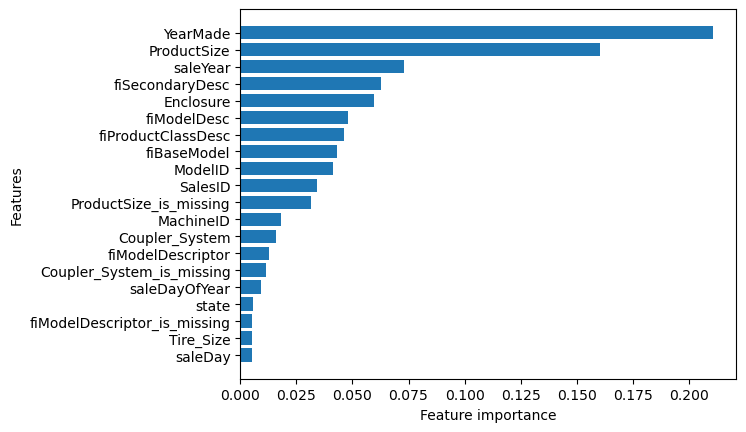

In [116]:
plot_features(X_train.columns, ideal_model.feature_importances_)